In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd

import time

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


In [3]:
BATCH_SIZE = 32
IMG_H, IMG_W = 224, 224
BUFFER_SIZE = 3000

## 設定路徑

In [4]:
PATH_TO_DATA = "../Comp4/task2/data/"
PATH_CKPTS = "../Comp4/task2/ckpts/16_resnet_cross/"

checkpoint_name = "16_resnet_cross"

In [5]:
MARGIN_C = 1.2
LEARNING_RATE = 1e-4
BETA = 0.5
EPOCHS = 130

CV_every = 5
SAVE_every = 5

In [6]:
aug_p = 0.9

up_down_flip_p = 0.25
left_right_flip_p = 0.5
rot_p = 0.5

In [7]:
def impute_answer(text):
    assert len(text) <= 9
    
    if len(text) == 9:
        return text
    
    need_char = 9 - len(text)
    return ("0" * need_char) + text

def get_q_a(folder, is_get_answer):
    tr_q = np.genfromtxt(PATH_TO_DATA + folder + "q.csv", delimiter=',').astype(np.int32).astype(str)

    tr_target = tr_q[:,0]
    tr_target = np.expand_dims(tr_target, 1)
    tr_target = np.repeat(tr_target, 9, axis=1)

    tr_candidate = tr_q[:,1:]

    if is_get_answer:
        tr_a = np.genfromtxt(PATH_TO_DATA + folder + "a.csv", delimiter=',').astype(np.int32).astype(str)    
        ans = []
        for i in range(tr_a.shape[0]):
            ans.append(list(impute_answer(tr_a[i, 1])))

        ans = np.asarray(ans).astype(np.int32)
        
        return tr_target, tr_candidate, ans
    else:
        return tr_target, tr_candidate

In [8]:
@tf.function
def image_preprocess(folder, img_name):
    img = tf.io.read_file(PATH_TO_DATA + folder + img_name + ".png")
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([IMG_H, IMG_W, 3])

    img = tf.cast(img, tf.float32)    
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    
    img = img[...,::-1]
    img = img - (103.939, 116.779, 123.68)
    
    return img

In [9]:
@tf.function
def random_flip(image):
    up_down_outcome = tf.random.uniform([1], 0, 1)
    right_left_outcome = tf.random.uniform([1], 0, 1)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)

    return image

@tf.function
def random_rot90(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < (rot_p/2):
        image = tf.image.rot90(image)
    elif (prob >= (rot_p/2)) and (prob < rot_p):
        image = tf.image.rot90(image, k=2)   
        
    return image

@tf.function
def image_augmentation(img):
    aug_sample = tf.random.uniform([1],0,1)
    
    if aug_sample < aug_p:
        img = random_flip(img)
        img = random_rot90(img)
    
    return img

In [10]:
tr_target, tr_candidate, tr_ans = get_q_a("s2_train/", is_get_answer=True)
val_target, val_candidate, val_ans = get_q_a("s2_valid/", is_get_answer=True)
te_target, te_candidate = get_q_a("s2_test/", is_get_answer=False)

# Dataset

In [11]:
class ds_train_generator(object):
    def __init__(self, target, candidate, answer, ds_folder):
        self.target = target[:, 0]
        self.candidate = candidate
        self.answer = answer
        self.ds_folder = ds_folder
        
    def preprocessing(self, target, candidate, answer):
        img_target = image_preprocess(self.ds_folder, target)
        
        qq = tf.random.uniform((), 0, 9)
        sample_idx = tf.cast(qq, tf.int32)
        sampled_candidate = tf.gather(candidate, sample_idx, axis=0)
        sampled_answer = tf.gather(answer, sample_idx, axis=0)
        
        img_candidate = image_preprocess(self.ds_folder, sampled_candidate)
        answer = tf.cast(sampled_answer, tf.float32)
        
        img_target = image_augmentation(img_target)
        img_candidate = image_augmentation(img_candidate)
        
        return img_target, img_candidate, answer
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.target,
                                                      self.candidate,
                                                      self.answer))
        dataset = dataset.map(self.preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [12]:
class ds_test_generator(object):
    def __init__(self, target, candidate, ds_folder):
        self.target = target.flatten()
        self.candidate = candidate.flatten()
        self.ds_folder = ds_folder
        
    def preprocessing(self, target, candidate):
        img_target = image_preprocess(self.ds_folder, target)
        img_candidate = image_preprocess(self.ds_folder, candidate)
        
        return img_target, img_candidate
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.target, self.candidate))
        dataset = dataset.map(self.preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [13]:
ds_train_gen = ds_train_generator(tr_target, tr_candidate, tr_ans, "s2_train_image/")
ds_train = ds_train_gen.generate()

In [14]:
ds_valid_gen = ds_test_generator(val_target, val_candidate, "s2_valid_image/")
ds_valid = ds_valid_gen.generate()

ds_test_gen = ds_test_generator(te_target, te_candidate, "s2_test_image/")
ds_test = ds_test_gen.generate()

# Model and Loss

In [15]:
class cnn_net(tf.keras.models.Model):
    def __init__(self):
        super(cnn_net, self).__init__()
        self.pre_resnet = tf.keras.applications.ResNet50(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=(IMG_H,IMG_W, 3))
        self.model = tf.keras.Model(inputs=self.pre_resnet.input, outputs= self.pre_resnet.output)
        self.model.trainable = False
        
        self.net1_flatten = tf.keras.layers.Flatten()
        self.net1_Dense = tf.keras.layers.Dense(1024, activation='relu', use_bias=False,
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.02))       
        self.net2_Dense = tf.keras.layers.Dense(512, activation='relu', use_bias=False, 
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.02))        
        self.net3_Dense = tf.keras.layers.Dense(256, activation='relu', use_bias=False,
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        
        self.net1_do = tf.keras.layers.Dropout(0.5)
        self.net2_do = tf.keras.layers.Dropout(0.5)
    
    def call(self, inputs):             
        net0 = self.model(inputs)
        
        net1 = self.net1_flatten(net0)
        net1 = self.net1_Dense(net1)
        net1 = self.net1_do(net1)
        
        net2 = self.net2_Dense(net1)
        net2 = self.net2_do(net2)
        
        net3 = self.net3_Dense(net2)
        
        outputs = net3

        return outputs

In [16]:
class pred_net(tf.keras.Model):
    def __init__(self):
        super(pred_net, self).__init__()
        self.L1_layer = tf.keras.layers.Lambda(lambda tensors:tf.math.abs(tensors[0] - tensors[1]))
        self.Dense = tf.keras.layers.Dense(1,
                                           activation='sigmoid',
                                           bias_initializer=tf.random_normal_initializer(mean=0.5,stddev=0.01))

    def call(self, target, candidate):
        L1_distance = self.L1_layer([target, candidate])
        pred = self.Dense(L1_distance)

        return pred

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def total_loss(true_answer, pred_answer):
    return cross_entropy(true_answer, pred_answer)

In [18]:
cnn_net = cnn_net()
pred_net = pred_net()
optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, beta_1 = BETA)

# Step

In [19]:
@tf.function
def train_step(target, candidate, answer):
    with tf.GradientTape() as tape:
        # Generate the encodings (feature vectors) for the two images
        target_output = cnn_net(target)
        candidate_output = cnn_net(candidate)
        
        #pred
        pred = pred_net(target_output, candidate_output)
        
        # loss
        loss = total_loss(answer, pred)
    
    grads = tape.gradient(loss, cnn_net.trainable_variables + pred_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_net.trainable_variables + pred_net.trainable_variables))
    
    return loss

In [20]:
@tf.function
def test_step(target, candidate):
    target_output = cnn_net(target)
    candidate_output = cnn_net(candidate)
    
    return pred_net(target_output, candidate_output)

In [21]:
def test(dataset):
    out = []

    for t, c in dataset:
        curr = test_step(t, c)
        out.extend(curr.numpy().tolist())
        
    out = np.asarray(out)
    out = np.reshape(out, (-1,9))
    
    return out

def cut_thres(y_pred, thres):
    y_pred = (y_pred > thres).astype(np.int32)
    
    return y_pred

def convert_to_int(y):
    output = []
    y = y.astype(str).tolist()
    
    for i in range(len(y)):
        output.append(int("".join(y[i])))
        
    return output

def convert_to_output(y):
    output = []
    y = y.astype(str).tolist()
    
    for i in range(len(y)):
        output.append("".join(y[i]))
        
    return output

def cal_acc(y_true, y_pred):
    output = []
    y_true = convert_to_int(y_true)
    y_pred = convert_to_int(y_pred)
    
    for i in range(len(y_true)):
        is_same = (y_true[i] == y_pred[i])
        output.append(int(is_same))
        
    return sum(output)/len(output)

def output(pred):
    pred = convert_to_output(pred)
    
    output = pd.DataFrame({"id": range(len(pred)),
                           "Category": pred})
    
    return output

In [22]:
def validation_acc(valid_dataset, val_ans):
    try_thre = [-0.9 + 0.1 * i for i in range(19)]
    acc_list = []
    
    val_pred = test(valid_dataset)
    
    for i in try_thre:
        val_pred_thres = cut_thres(val_pred, i)
        acc_list.append(cal_acc(val_ans, val_pred_thres))
    
    print("Validation Acc: ", max(acc_list))
    
    return max(acc_list)

# Checkpoint

In [23]:
last_ckp = tf.train.latest_checkpoint(PATH_CKPTS)
start_epoch = 0

if last_ckp:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, cnn_net=cnn_net, pred_net = pred_net)
    ckpt.restore(last_ckp)
    start_epoch = int(last_ckp.split("-")[-1])

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 100


In [24]:
ckpt = tf.train.Checkpoint(optimizer=optimizer, cnn_net=cnn_net, pred_net = pred_net)

manager = tf.train.CheckpointManager(ckpt, PATH_CKPTS, max_to_keep=25,
                                     checkpoint_name=checkpoint_name)

# Training

In [ ]:
loss_hist = {}
val_hist = {}

for i in range(start_epoch, EPOCHS):
    epoch = i + 1
    total_loss_list = []
    start = time.time()
    
    print("Epoch:", epoch)
    
    for tar, can, ans in ds_train:
        tmp_loss = train_step(tar, can, ans)
        # print("Current loss: {}".format(tmp_loss),end="\r")
        total_loss_list.append(tmp_loss)
        
    if epoch % CV_every == 0:
        val_acc = validation_acc(ds_valid, val_ans)
        val_hist[epoch] = val_acc
        
    print("Cross Entropy Loss: {}".format(np.mean(total_loss_list)))
    print('Time for epoch {} is {} sec\n'.format(epoch, time.time()-start))
    
    if epoch % SAVE_every == 0:
        manager.save(checkpoint_number=epoch)
        
    loss_hist[epoch] = np.mean(total_loss_list)

Epoch: 101


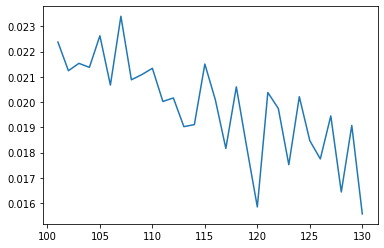

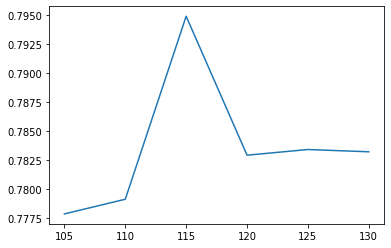

In [26]:
plt.plot(list(loss_hist.keys()), list(loss_hist.values()))
plt.show()

plt.plot(list(val_hist.keys()), list(val_hist.values()))
plt.show()

In [27]:
val_hist

{105: 0.77783203125,
 110: 0.7791015625,
 115: 0.794921875,
 120: 0.78291015625,
 125: 0.7833984375,
 130: 0.783203125}

# Validatoin and Testing

In [29]:
last_ckp = PATH_CKPTS + "16_resnet_cross-115" # tf.train.latest_checkpoint(PATH_CKPTS)
start_epoch = 0

if last_ckp:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, cnn_net=cnn_net, pred_net = pred_net)
    ckpt.restore(last_ckp)
    start_epoch = int(last_ckp.split("-")[-1])

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 115


In [30]:
val_pred = test(ds_valid)

In [47]:
COSINE_THRE = 0.21

In [48]:
val_pred_thres = cut_thres(val_pred, 0.21)
val_acc = cal_acc(val_ans, val_pred_thres)
print("Validation Acc: ", val_acc)

Validation Acc:  0.7951171875


In [49]:
te_pred = test(ds_test)

In [50]:
te_pred_thres = cut_thres(te_pred, COSINE_THRE)
output_df = output(te_pred_thres)

In [51]:
output_df.to_csv("../output/{}_{}.csv".format(checkpoint_name, start_epoch), index=False)